In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from main import build_loaders, make_train_valid_dfs

train_dataframe, valid_dataframe = make_train_valid_dfs()

/home/gridsan/nchutisilp/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torchio as tio
import pandas as pd
import config as CFG
import numpy as np
import torch

def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/pre_post_coregistration.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

def get_optimized_dataloaders(image_filenames1, image_filenames2, transforms):
    subjects = []
    for image_path1, image_path2 in zip(image_filenames1, image_filenames2):
        subject = tio.Subject(
            image1=tio.ScalarImage(image_path1),
            image2=tio.ScalarImage(image_path2),
            non_zero_mask1=tio.ScalarImage(image_path1),
        )
        subjects.append(subject)
    subjects_dataset = tio.SubjectsDataset(subjects, transform=transforms)
    patches_queue = tio.Queue(
        subjects_dataset,
        max_length=3,
        samples_per_volume=1,
        sampler=tio.data.WeightedSampler(patch_size=[512, 512, 32], probability_map="non_zero_mask1"),
        num_workers=1,
        shuffle_subjects=True,
    )
    patches_loader = torch.utils.data.DataLoader(
        patches_queue,
        batch_size=2,
        num_workers=0,  # this must be 0
    )
    return patches_loader

def get_torchio_transforms(mode="train"):
    if mode == "train":
        return tio.transforms.Compose(
            [
                tio.transforms.CropOrPad((CFG.CROP_SIZE, CFG.CROP_SIZE, 375)),
                tio.transforms.Resize((CFG.IMG_SIZE_W, CFG.IMG_SIZE_H, 375)),
                tio.transforms.ZNormalization(exclude=["non_zero_mask1"])
            ]
        )
    else:
        return tio.transforms.Compose(
            [
                tio.transforms.CropOrPad((CFG.CROP_SIZE, CFG.CROP_SIZE, 375)),
                tio.transforms.Resize((CFG.IMG_SIZE_W, CFG.IMG_SIZE_H, 375)),
                tio.transforms.ZNormalization(exclude=["non_zero_mask1"])
            ]
        )

def build_loaders(dataframe, mode):
    transforms = get_torchio_transforms(mode=mode)
    dataloader = get_optimized_dataloaders(
        image_filenames1=dataframe["image1"].values,
        image_filenames2=dataframe["image2"].values,
        transforms=transforms,
    )
    return dataloader

train_dataframe, valid_dataframe = make_train_valid_dfs()
train_dl = build_loaders(dataframe=train_dataframe, mode='train')
for data in train_dl:
    break

# data['image1'].shape, data['image2'].shape

In [ ]:
data.keys()

In [ ]:
valid_loader = build_loaders(valid_dataframe, mode="valid")
for data in valid_loader:
    break
data['image1'].shape, data['image2'].shape

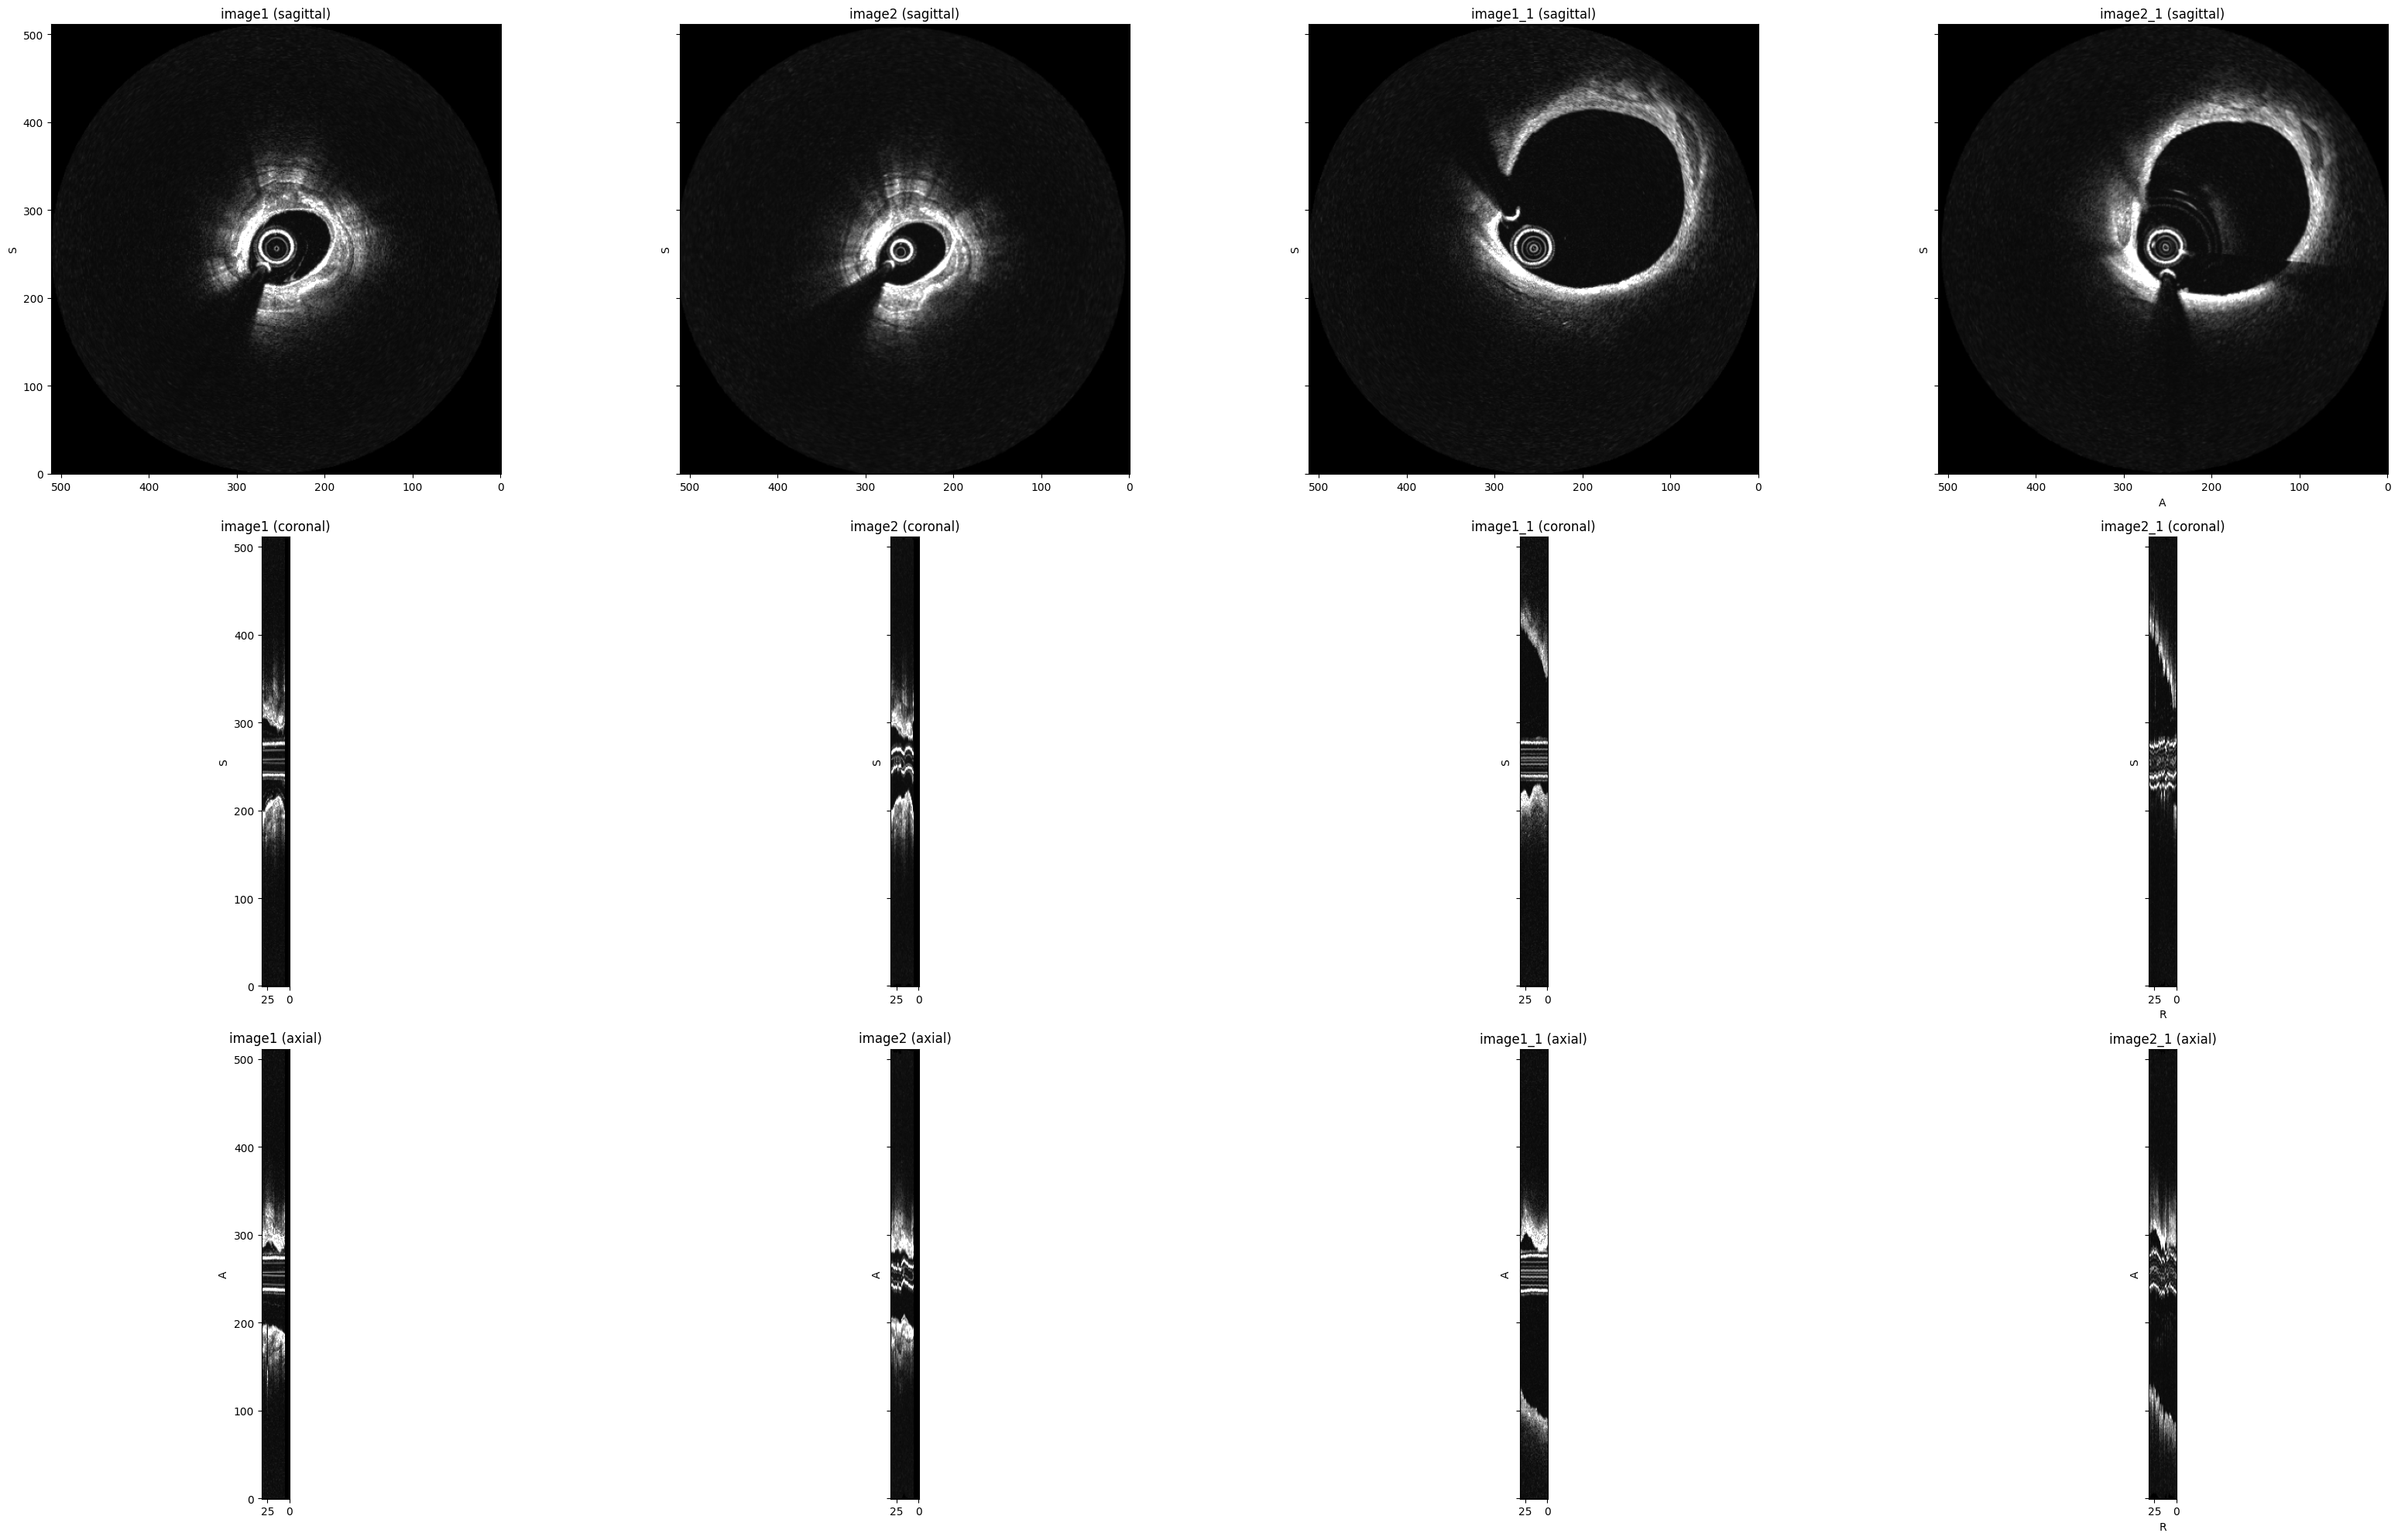

In [6]:
%matplotlib inline
import torchio as tio

tio.Subject(
    image1=tio.ScalarImage(tensor=data['image1'][tio.DATA].permute(0, 1, 4, 3, 2)[0]),
    image2=tio.ScalarImage(tensor=data['image2'][tio.DATA].permute(0, 1, 4, 3, 2)[0]),
    image1_1=tio.ScalarImage(tensor=data['image1'][tio.DATA].permute(0, 1, 4, 3, 2)[1]),
    image2_1=tio.ScalarImage(tensor=data['image2'][tio.DATA].permute(0, 1, 4, 3, 2)[1]),
).plot(figsize=(40,20))

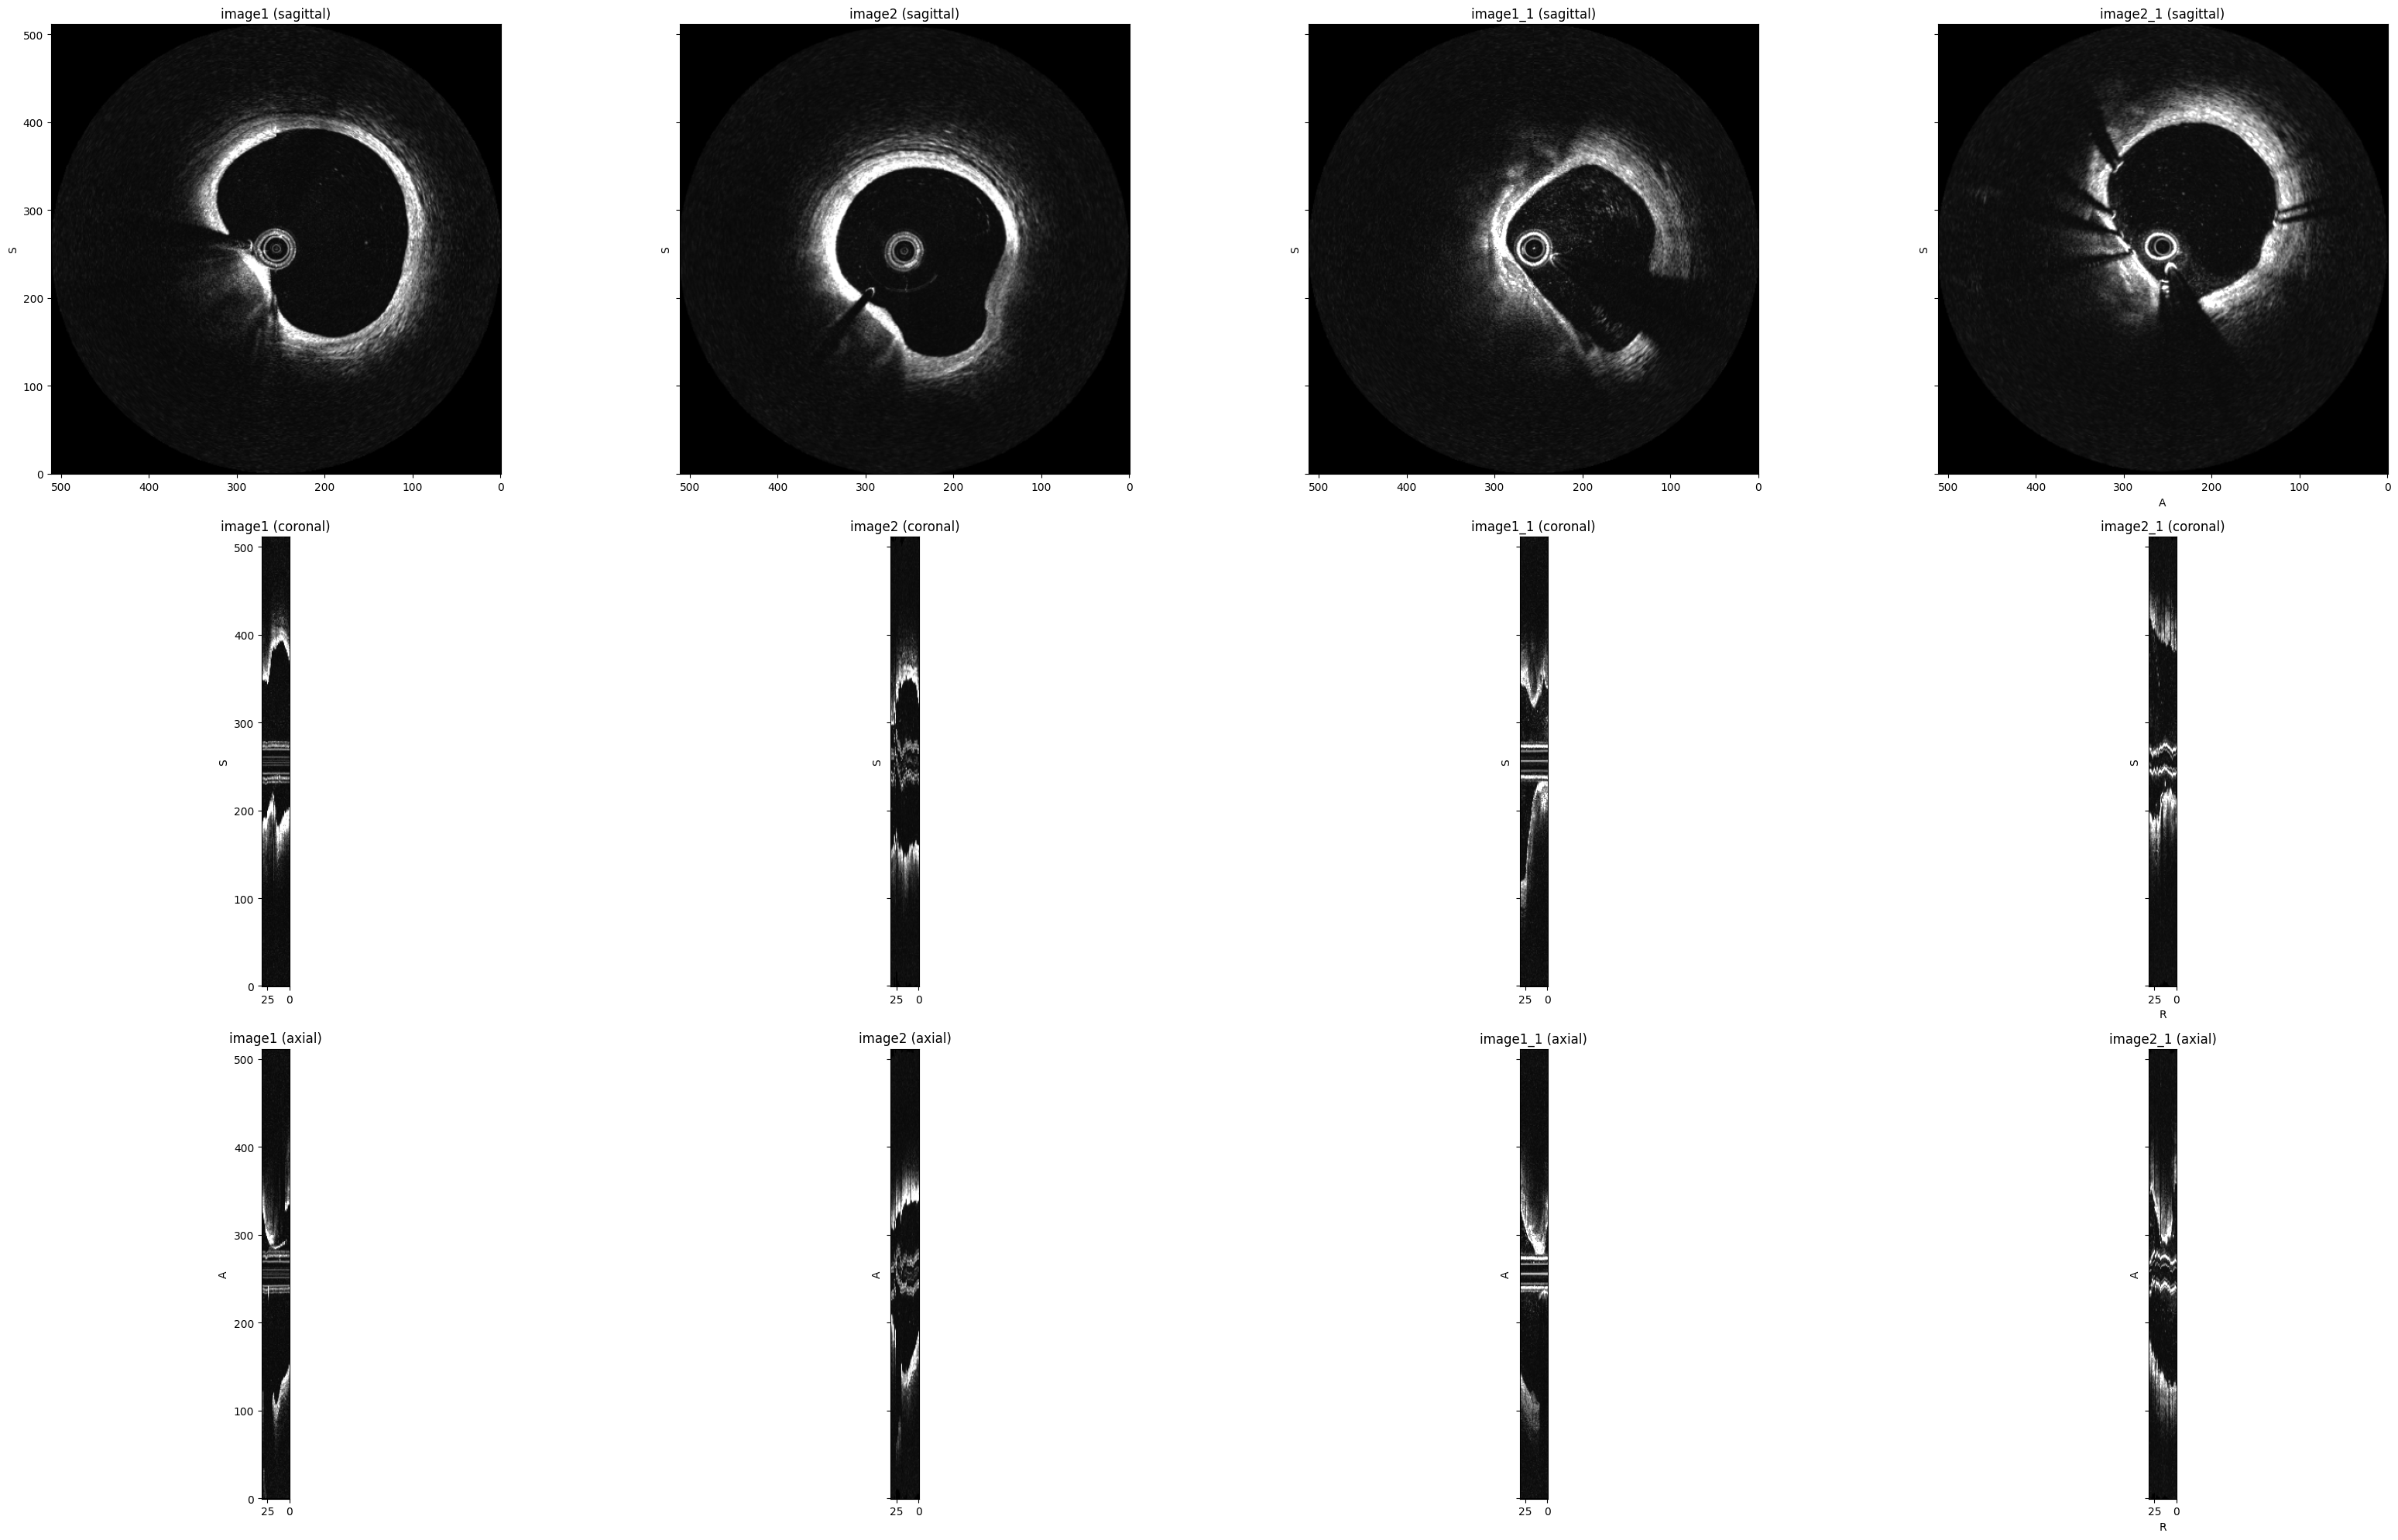

In [11]:
tio.Subject(
    image1=tio.ScalarImage(tensor=data['image1'][2]),
    image2=tio.ScalarImage(tensor=data['image2'][2]),
    image1_1=tio.ScalarImage(tensor=data['image1'][3]),
    image2_1=tio.ScalarImage(tensor=data['image2'][3]),
).plot(figsize=(40,20))

In [4]:
from CLIP import CLIPModel
import config as CFG

model = CLIPModel().to(CFG.device)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Using device: cpu

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2024-07-18 10:21:38.932518: Using torch.compile...


/home/gridsan/nchutisilp/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Using device: cpu

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2024-07-18 10:21:41.310406: Using torch.compile...


/home/gridsan/nchutisilp/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
import torch

model.eval()
with torch.no_grad():
    with torch.autocast(device_type="cpu", dtype=torch.bfloat16):
        batch = {k: v.to(CFG.device) for k, v in list(data.items())[:2] if k not in ["caption", "image_path1", "image_path2", "image_z_index"]}
        loss = model(batch, mode="valid")
        print(loss)